# Read in data and set up plotting

In [168]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import ast
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt 
from numpy.random import permutation
import random 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()


def clean_condition_col(x):
    if x == "f_l":
        return "LowExposure\nLabeled"
    elif x == "f_u":
        return "LowExposure\nUnlabeled"
    elif x == "m_l":
        return "HiExposure\nLabeled"
    elif x == "m_u":
        return "HiExposure\nUnlabeled"
    elif x == "h":
        return "HumanControl"
    
df = pd.read_csv("../../data/experiment_data/data_clean_with_elab.csv")
df['init_array'] = df['init_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df.head() 

,Unnamed: 0,response_id,participant_id,response_text,response_date,condition,condition_order,item,response_chain,init_array,...,idea6_txt,idea_minus_excluded6_txt,source,trial_no,trial_no_excluded,elab_ibf,elab_ipf,elab_not_sw,elab_n_tokens,clean_condition
0,0,99ae32b8-e477-4d42-a98f-1a11116a8779,5c6d9a7d-79f2-491e-8592-5a4917313807,Dog chew toy,2023-07-26 02:15:58,f_l,3,shoe,6,"[5bc110cc-fea3-4728-bdba-e3a884bd63ff, ai_seed...",...,Convey that you're selling drugs,Convey that you're selling drugs,r/artificial,19,19.0,2.463967,8.755670,3,3,LowExposure\nLabeled
1,1,632754e7-8297-4c55-91ec-485164c851f2,a062f627-4225-4634-9441-b6b41e0fe42f,Use the shoe as a ruler,2023-07-26 17:56:06,f_l,0,shoe,6,"[5d624ef0-ad38-441d-8982-86ad7da86fb1, 9d8bace...",...,Dog chew toy,Dog chew toy,r/singularity,20,20.0,2.954592,8.905649,3,6,LowExposure\nLabeled
2,2,052f291a-1f95-4154-b217-504009cc5127,5c6d9a7d-79f2-491e-8592-5a4917313807,Kicking object to release stress,2023-07-26 02:14:34,m_l,2,tire,6,"[2c277bc2-10b6-42f0-876c-f0a86bf0eaa6, ai_seed...",...,diy ottoman or footstool,diy ottoman or footstool,r/artificial,19,18.0,3.809144,11.173407,4,5,HiExposure\nLabeled
3,3,312cc305-86b0-4d72-97ea-d5b551618376,a062f627-4225-4634-9441-b6b41e0fe42f,use it as a damper,2023-07-26 18:02:28,h,2,tire,6,"[353a7741-c733-4ca1-988c-a809c2b24df6, d1087ef...",...,Carve the tire into a portrait of the first lady,Carve the tire into a portrait of the first lady,r/singularity,19,19.0,2.763950,6.175155,2,5,HumanControl
4,4,1d7fb44d-adba-4ac4-9360-4126b214c2ae,b904b2d5-0217-41bf-9741-5203f3f46e34,use a a toy for pets to hide in and explore,2023-07-26 16:46:37,m_l,3,tire,6,"[ai_seed1238, 052f291a-1f95-4154-b217-504009cc...",...,fitness tool - tire flipping!,fitness tool - tire flipping!,Creative Mornings newsletter,20,19.0,4.684683,13.661652,5,11,HiExposure\nLabeled


# Get embeding of all ideas

The goal is to get a hash map `idea2vec` where key is text and value is sbert vector

In [169]:
model = SentenceTransformer('all-MiniLM-L6-v2')
example_cols = [x for x in df.columns if "_txt" in x and "excluded" not in x]

# Gather all ideas
df['init_array_list'] = df[example_cols].values.tolist()
all_ideas = []
all_ideas.extend(df['response_text'])
for x in example_cols:
    all_ideas.extend(df[x].to_list())
all_ideas = list(set(all_ideas))

# Get embeddings and create idea2vec mapping
embeddings = model.encode(all_ideas)
idea2vec = dict(zip(all_ideas, embeddings))

# Compute semantic diversity metrics

In [170]:
def semantic_distances(row, idea2vec):
    response_text = row['response_text']
    example_list = row['init_array_list']
    example_rids = row['init_array']

    ai_ideas = [example_list[i] for i in range(len(example_list)) if "ai" in example_rids[i].lower()]

    idea_vec = idea2vec[response_text]
    example_vecs = [idea2vec[example] for example in example_list]
    ai_example_vecs = [idea2vec[example] for example in ai_ideas]
    union_vecs = example_vecs + [idea_vec]

    distances = pdist(union_vecs, "euclidean")
    
    # distance between idea_vec and centroid of example_vecs
    centroid = np.mean(example_vecs, axis=0)
    cent_dist = cdist([idea_vec], [centroid])

    # max similarity and max distance for ai_example_vecs
    if ai_example_vecs:
        ai_sim = np.max(cosine_similarity([idea_vec], ai_example_vecs))
        ai_dist = np.max(cdist([idea_vec], ai_example_vecs))
    else:
        ai_sim = 0
        ai_dist = 0

    return pd.Series({
        'avg_pw_dist': np.mean(distances),
        'cent_dist': cent_dist[0][0],
        'ai_sim': ai_sim,
        'ai_dist': ai_dist,
        'median_pw_dist': np.median(distances),
        'min_pw_dist': np.min(distances),
        'max_pw_dist': np.max(distances),

        
    })

semantic_measures_df = df.apply(lambda row: semantic_distances(row, idea2vec), axis=1)
df = pd.concat([df, semantic_measures_df], axis=1)
df = df.query("exclude_from_analysis==0")

# Inferential Statistics

- We will first do a Kruskal Wallis test to see if the `dv` differs by `condition`. This is a non-parametric equivalent to ANOVA

- Then if we reject the null of homogenity, we do permutation tests on the difference in medians with an fdr correction for multiple comparisons

We conducted a Kruskal Wallis test and found avg_pw_dist differed by clean_condition, H=247.57, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,0.019073,0.397262,0.000000,YES
1,LowExposure\nLabeled,HumanControl,-0.008808,-0.220643,0.000429,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.021042,0.432639,0.000000,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.004076,-0.108948,0.116111,NO
4,HiExposure\nLabeled,HumanControl,-0.027881,-0.558744,0.000000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.001969,0.034476,0.624000,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.023149,-0.483121,0.000000,YES
7,HumanControl,HiExposure\nUnlabeled,0.029850,0.591074,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,0.004733,0.118891,0.053625,NO
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.025118,-0.517449,0.000000,YES


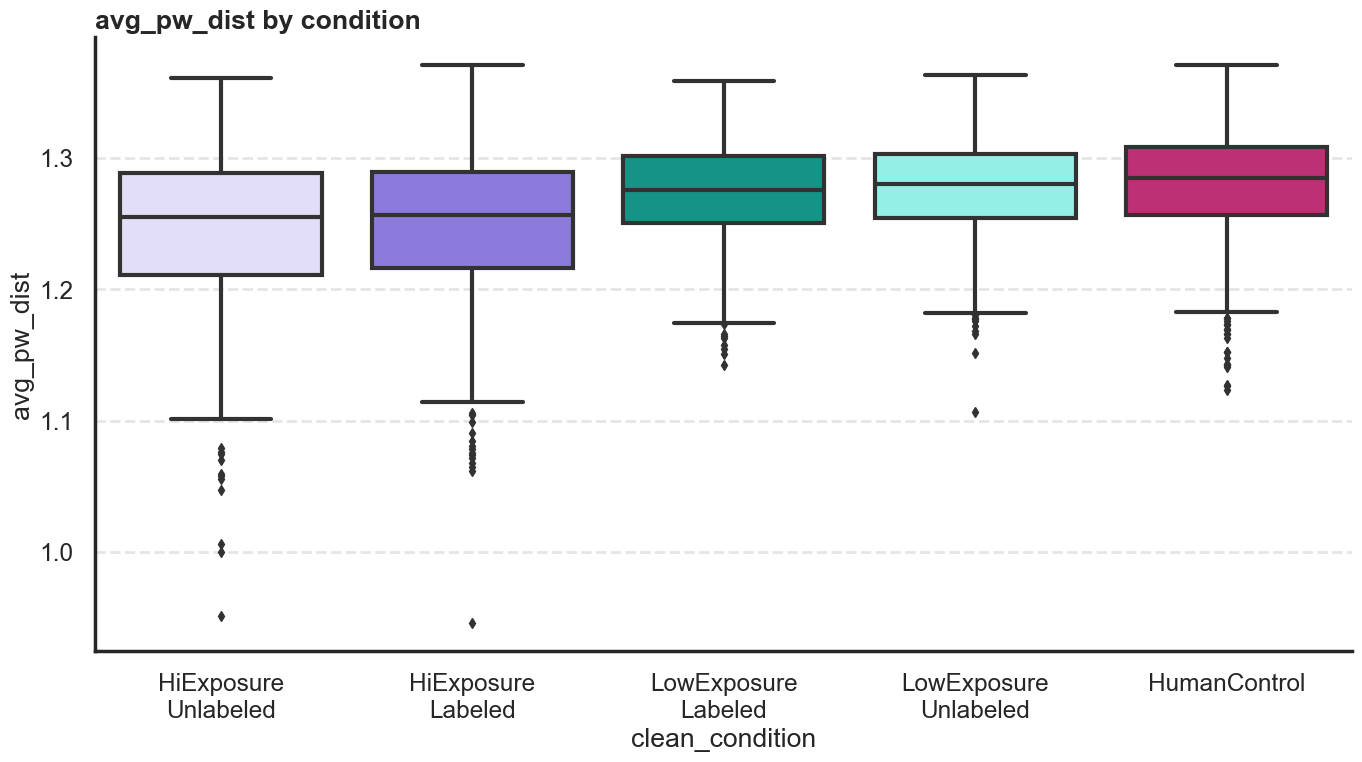

We conducted a Kruskal Wallis test and found cent_dist differed by clean_condition, H=96.6, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,-0.029265,-0.420523,0.000000,YES
1,LowExposure\nLabeled,HumanControl,-0.005314,-0.078361,0.359000,NO
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.025942,-0.358981,0.000000,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.005844,-0.089752,0.353000,NO
4,HiExposure\nLabeled,HumanControl,0.023951,0.338905,0.000000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.003323,0.044328,0.515000,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,0.023421,0.343994,0.000000,YES
7,HumanControl,HiExposure\nUnlabeled,-0.020628,-0.281397,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,-0.000530,-0.008000,0.871700,NO
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.020098,0.283806,0.000167,YES


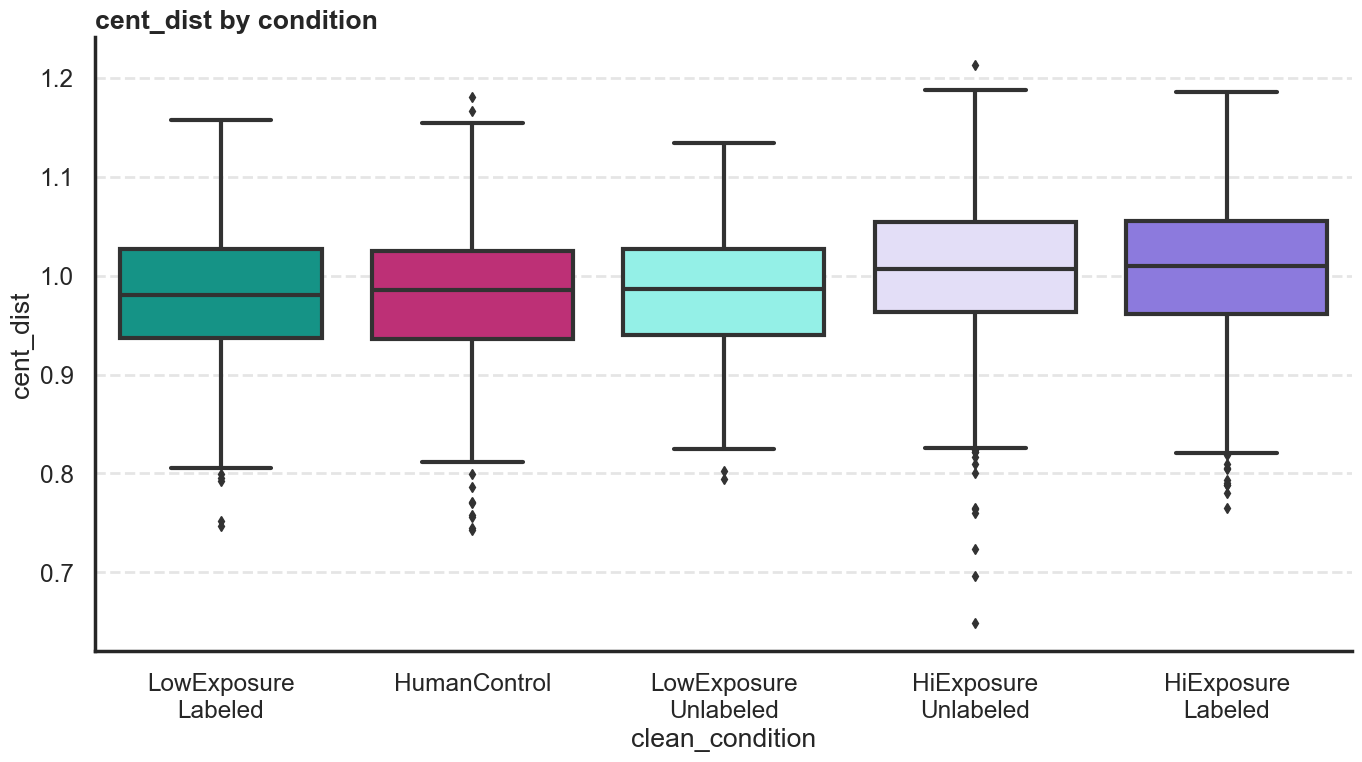

We conducted a Kruskal Wallis test and found ai_sim differed by clean_condition, H=1690.36, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,-0.025733,-0.217169,0.000000,YES
1,LowExposure\nLabeled,HumanControl,0.211109,2.511807,0.000000,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.031276,-0.255844,0.000000,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,0.015010,0.129649,0.054111,NO
4,HiExposure\nLabeled,HumanControl,0.236842,2.835485,0.000000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.005543,-0.045475,0.454900,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,0.040743,0.353066,0.000000,YES
7,HumanControl,HiExposure\nUnlabeled,-0.242385,-2.730421,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,-0.196099,-2.462844,0.000000,YES
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.046286,0.388147,0.000000,YES


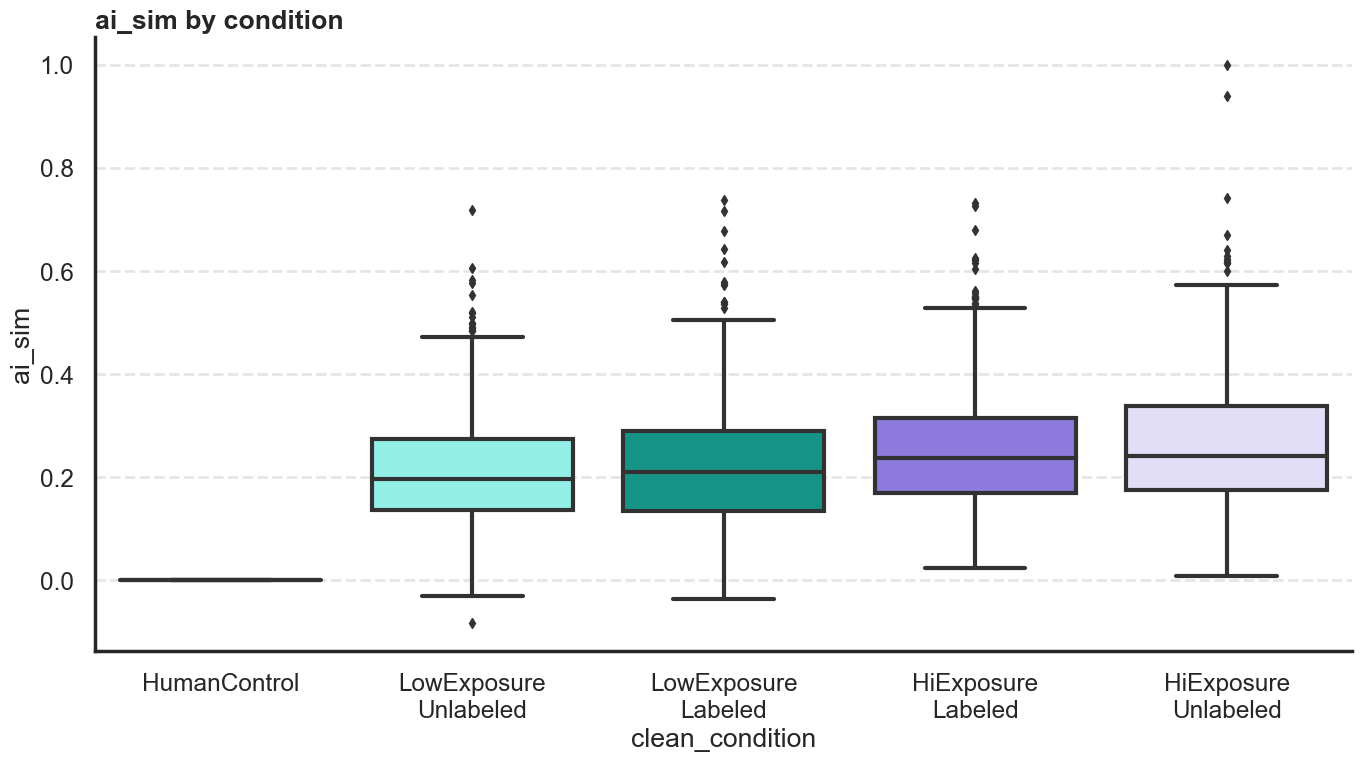

We conducted a Kruskal Wallis test and found ai_dist differed by clean_condition, H=1725.04, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,-0.028545,-0.405316,0.000000,YES
1,LowExposure\nLabeled,HumanControl,1.332949,25.343581,0.000000,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.029026,-0.405905,0.000000,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.004874,-0.066803,0.404778,NO
4,HiExposure\nLabeled,HumanControl,1.361494,29.068677,0.000000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.000480,-0.007128,0.890200,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,0.023671,0.343391,0.000000,YES
7,HumanControl,HiExposure\nUnlabeled,-1.361975,-28.112341,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,-1.337823,-26.451540,0.000000,YES
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.024151,0.344835,0.000000,YES


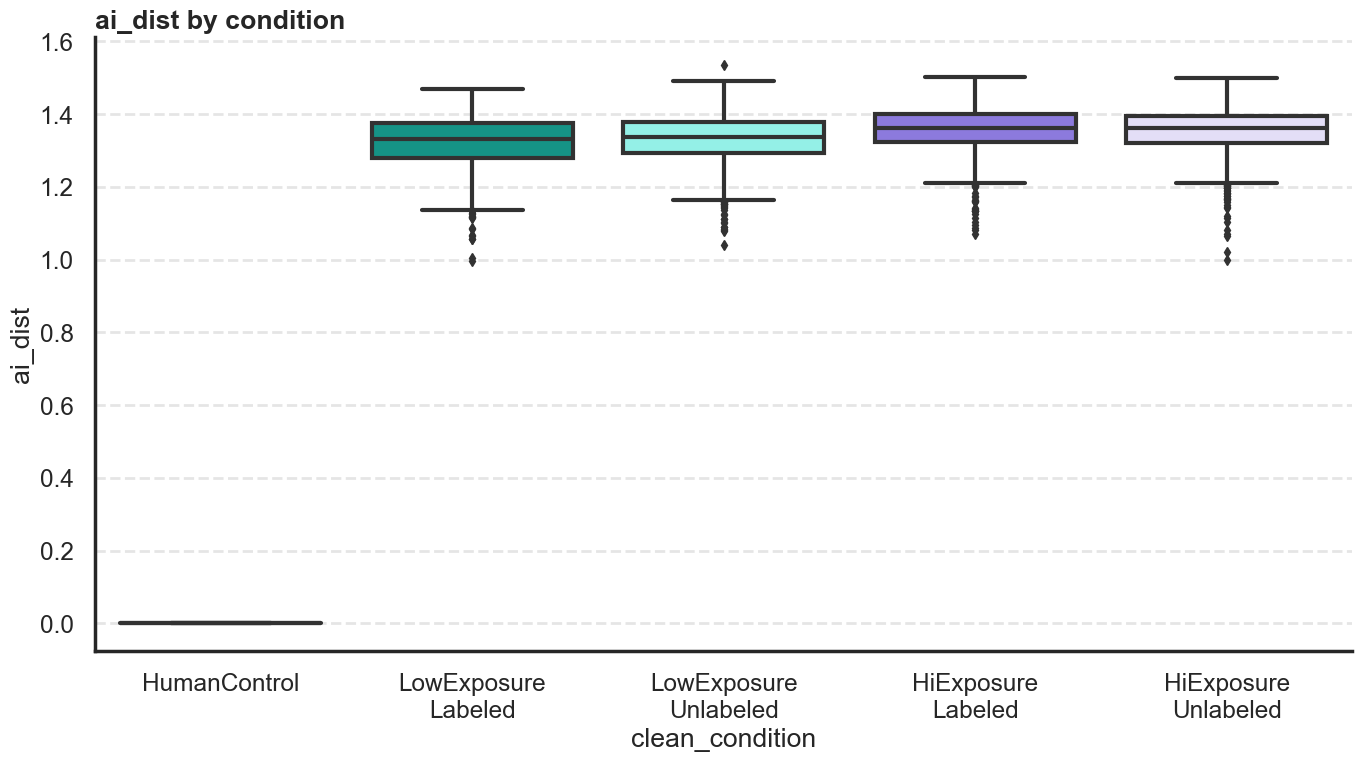

We conducted a Kruskal Wallis test and found median_pw_dist differed by clean_condition, H=27.88, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,0.005818,0.127087,0.032833,YES
1,LowExposure\nLabeled,HumanControl,-0.002980,-0.074774,0.270857,NO
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.006964,0.151186,0.021800,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.002234,-0.058413,0.424750,NO
4,HiExposure\nLabeled,HumanControl,-0.008798,-0.181989,0.000500,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.001146,0.021391,0.803111,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.008052,-0.171209,0.009000,YES
7,HumanControl,HiExposure\nUnlabeled,0.009944,0.204562,0.000500,YES
8,HumanControl,LowExposure\nUnlabeled,0.000745,0.018056,0.887300,NO
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.009198,-0.194437,0.009000,YES


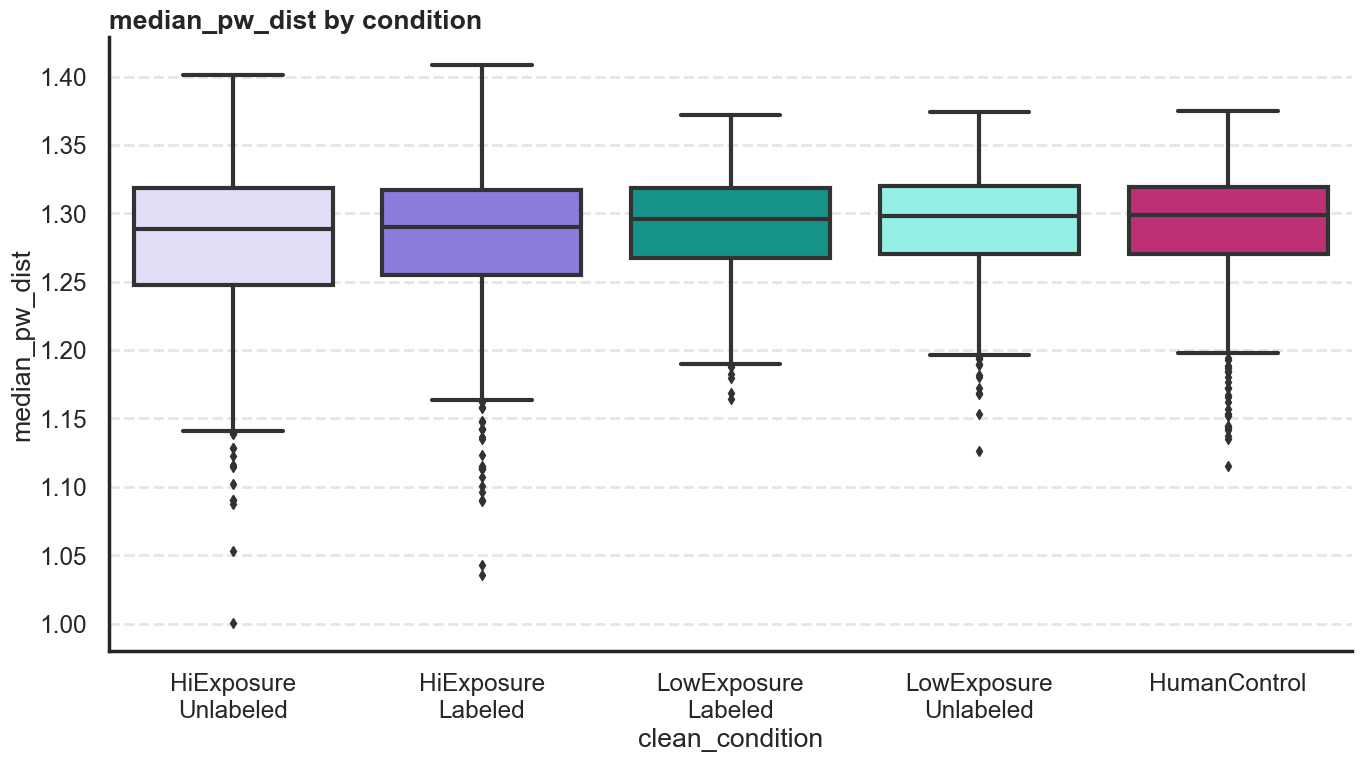

We conducted a Kruskal Wallis test and found min_pw_dist differed by clean_condition, H=615.35, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,0.126759,0.503337,0.000000,YES
1,LowExposure\nLabeled,HumanControl,-0.057696,-0.315753,0.000000,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.127890,0.509650,0.000000,YES
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.010638,-0.053002,0.279556,NO
4,HiExposure\nLabeled,HumanControl,-0.184454,-0.776871,0.000000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.001131,0.003859,0.889100,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.137396,-0.546247,0.000000,YES
7,HumanControl,HiExposure\nUnlabeled,0.185586,0.784791,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,0.047058,0.258139,0.000000,YES
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.138528,-0.552725,0.000000,YES


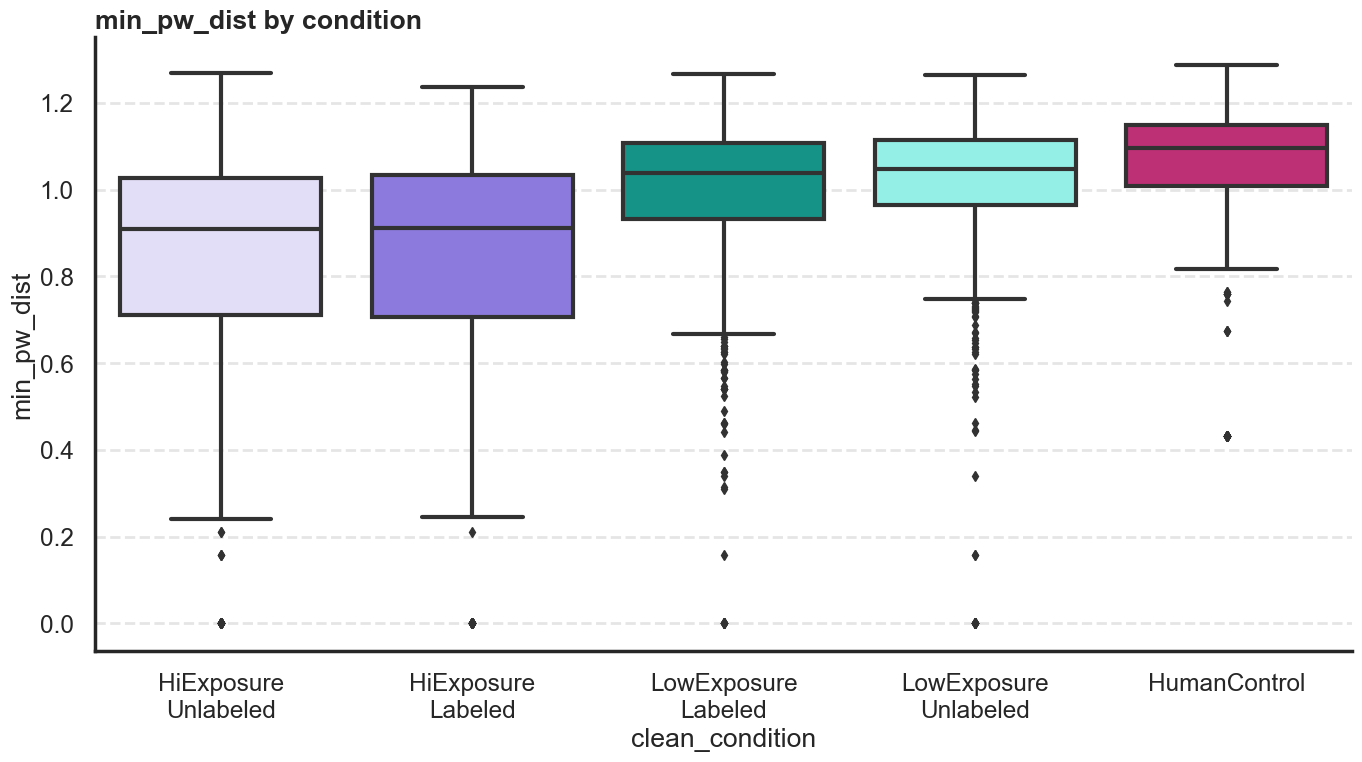

We conducted a Kruskal Wallis test and found max_pw_dist differed by clean_condition, H=15.9, p=0.0


,group1,group2,Diff in Medians,Diff in Medians/Pooled SD,p_adj,Reject Null
0,LowExposure\nLabeled,HiExposure\nLabeled,0.000898,0.024185,0.774600,NO
1,LowExposure\nLabeled,HumanControl,-0.000771,-0.021368,0.653889,NO
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.002048,0.056396,0.653889,NO
3,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.002689,-0.080031,0.477000,NO
4,HiExposure\nLabeled,HumanControl,-0.001669,-0.043006,0.653889,NO
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.001150,0.029463,0.653889,NO
6,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.003587,-0.098228,0.477000,NO
7,HumanControl,HiExposure\nUnlabeled,0.002819,0.074132,0.510600,NO
8,HumanControl,LowExposure\nUnlabeled,-0.001918,-0.054125,0.477000,NO
9,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.004737,-0.132741,0.247000,NO


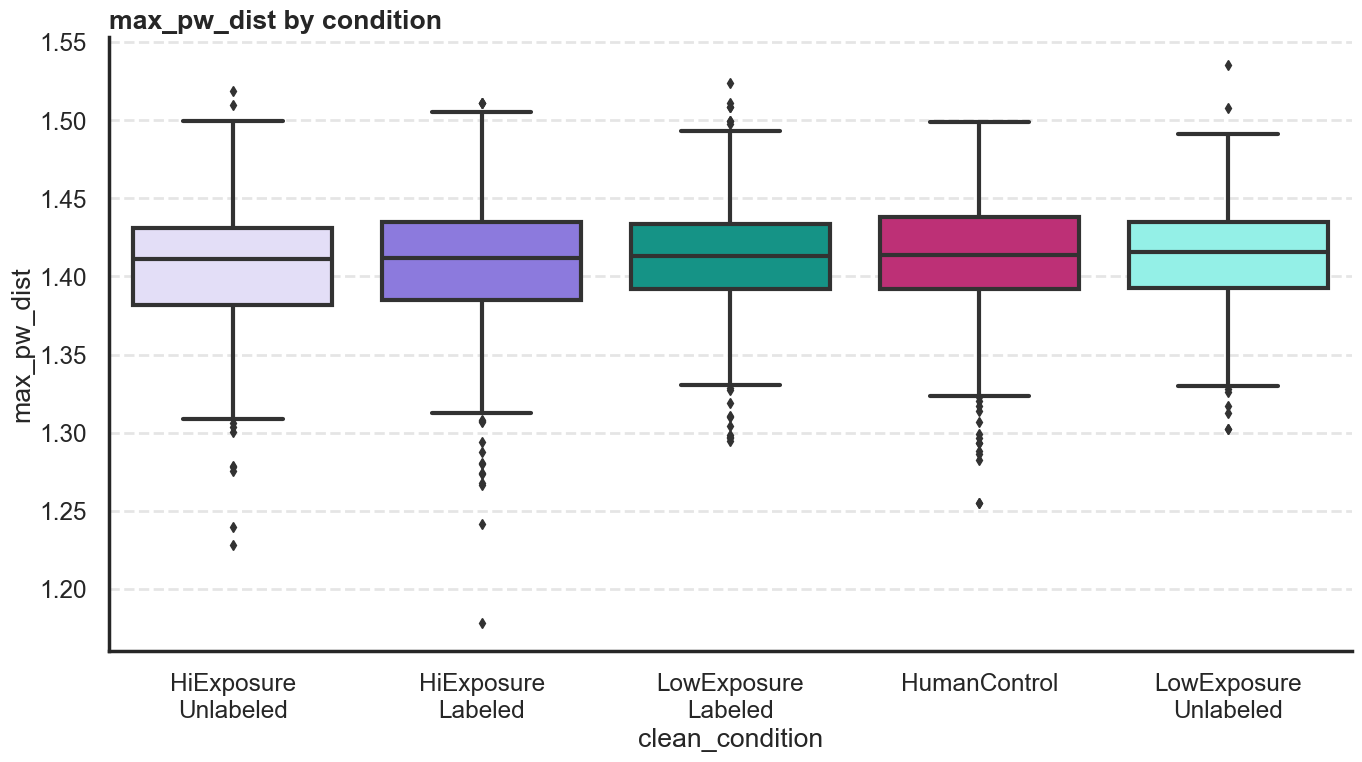

In [178]:
from numpy.random import permutation
import random 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
import pandas as pd

def plot_distributions(df, group_col, data_col):
    # We have many graphs, need to have each condition mapped to consistent color
    color_dict = {'LowExposure\nLabeled':'#00A896', 
              'LowExposure\nUnlabeled':'#85FFF3',
              'HumanControl':'#D41876',
              'HiExposure\nLabeled':'#826AED', 
              'HiExposure\nUnlabeled':'#E0DAFB',   
             }
    order = df.groupby(group_col)[dv].median().sort_values().index
    plt.figure(figsize=(14,8))
    sns.boxplot(data=df, x='clean_condition', y=dv, order=order, palette=color_dict)
    plt.title(f"{dv} by condition")
    plt.show()


def kruskal_wallis(df, group_col, data_col):
    """Kurskal Wallis test for non-parametric group differences"""
    H, p = stats.kruskal(*[group[dv].values for name, group in df.groupby("condition")])
    if p < 0.05:
        print(f"We conducted a Kruskal Wallis test and found {data_col} differed by {group_col}, H={np.round(H, 2)}, p={np.round(p)}")
    return H, pval

def pairwise_permutation(df, group_col, data_col, num_permutations=10000):
    """Concducts pairwise permutation tests with FDR correction"""
    groups = df[group_col].unique()
    group_pairs = list(itertools.combinations(groups, 2))
    results = []

    for group1, group2 in group_pairs:
        group1_data = df[df[group_col] == group1][data_col]
        group2_data = df[df[group_col] == group2][data_col]
        
        # Perform permutation test
        p = perm_test(group1_data, group2_data, num_permutations)
        
        # Calculate the difference of medians
        median_diff = np.median(group1_data) - np.median(group2_data)
        pooled_sd = sqrt((group1_data.std() ** 2 + group2_data.std() ** 2) / 2)
        ef_size = median_diff / pooled_sd
        results.append([group1, group2, median_diff,ef_size, p])

    results_df = pd.DataFrame(results, columns=['group1', 'group2', 'Diff in Medians', 'Diff in Medians/Pooled SD','p'])
    reject, pvals_corrected, _, _ = multipletests(results_df['p'], method='fdr_bh')
    results_df['p_adj'] = pvals_corrected
    results_df = results_df.drop(columns='p')
    results_df['Reject Null'] = results_df['p_adj'].apply(lambda x: 'YES' if x < 0.05 else 'NO')
    return results_df

def perm_test(x, y, num_permutations):
    """Conducts a permutation test, returns p-value"""
    np.random.seed(416)
    random.seed(416)
    n = len(x)
    diff = np.abs(np.median(x) - np.median(y))
    combined = np.concatenate((x, y))
    count = 0
    for i in range(num_permutations):
        perm = permutation(combined)
        pcurrent = perm[:n]
        pnew = perm[n:]
        diffperm = np.abs(np.median(pcurrent) - np.median(pnew))
        if diffperm > diff:
            count += 1
    return count / num_permutations


dist_metrics = [x for x in df.columns if "sim" in x or "dist" in x]
for dv in dist_metrics:
    kruskal_wallis(df, "clean_condition", dv)
    display(pairwise_permutation(df, "clean_condition", dv))
    plot_distributions(df, "clean_condition", dv)